In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
from tqdm import tqdm
import requests
import shutil
import dlib

## FIFA 22 complete player dataset

https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset

In [66]:
# %%
data_path = 'dataset'
data_imgs_path = f'{data_path}/imgs'
model_path = 'model'
pretrained_arcface_model = f'{model_path}/model.tflite'
model_name = f'{model_path}/face-reader-soccer.h5'
x_data_filename = 'x_data_file.pickle'
y_data_filename = 'y_data_file.pickle'

if not os.path.exists(data_path):
    os.makdirs(data_path)
if not os.path.exists(data_imgs_path):
    os.makdirs(data_imgs_path)
if not os.path.exists(model_path):
    os.makdirs(model_path)

In [67]:
if os.path.exists(f'{data_path}/players_22.csv'):
    print(f'{data_path}/players_22.csv exists.')
else:
    !wget https://github.com/kairess/toy-datasets/raw/master/players_22.csv -O {data_path}/players_22.csv


dataset/players_22.csv exists.


In [68]:
son = df.loc[df['short_name'] == 'H. Son']
#df.iloc[son_id]
son_idx = son.index[0]
df.iloc[son_idx]

sofifa_id                                                      200104
player_url          https://sofifa.com/player/200104/heung-min-son...
short_name                                                     H. Son
long_name                                                     손흥민 孙兴慜
player_positions                                           LM, CF, LW
                                          ...                        
player_face_url     https://cdn.sofifa.net/players/200/104/22_120.png
club_logo_url                  https://cdn.sofifa.net/teams/18/60.png
club_flag_url                 https://cdn.sofifa.net/flags/gb-eng.png
nation_logo_url                                                   NaN
nation_flag_url                   https://cdn.sofifa.net/flags/kr.png
Name: 13, Length: 110, dtype: object

In [69]:
df.iloc[son_idx]['wage_eur'] # 주급(유로)

220000.0

In [70]:
df.iloc[son_idx]['overall'] # player current overall attribute 플레이어 종합 점수

89

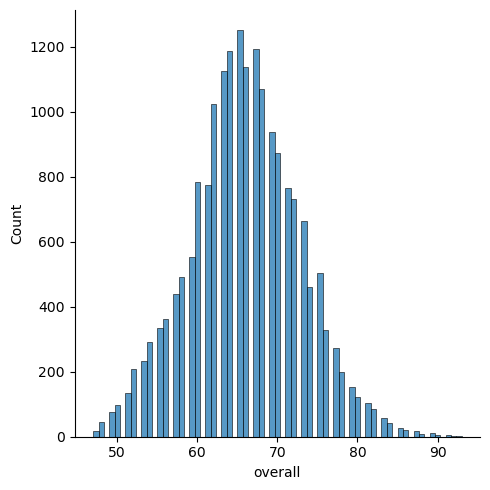

In [71]:
sns.displot(df['overall'])

## Face image download

will take 40 minutes

In [72]:
def download_face_images(data_imgs_path):
    if os.path.exists(data_imgs_path) is False:
        os.makedirs(data_imgs_path, exist_ok=True)

        for i, row in tqdm(df.iterrows()):
            img_url = row['player_face_url']
            overall = row['overall']

            r = requests.get(img_url, stream=True, headers={'User-agent': 'Mozilla/5.0'})

            if r.status_code == 200:
                with open('imgs/%s_%s.png' % (i, overall), 'wb') as f:
                    r.raw.decode_content = True
                    shutil.copyfileobj(r.raw, f)
            else:
                print(row['short_name'])
    else:
        print(f'{data_imgs_path} folder already exists.')

In [73]:
download_face_images(data_imgs_path)

dataset/imgs folder already exists.


## Arcface face recognition package

https://pypi.org/project/arcface

In [74]:
!pip install -q arcface

## Face recognition

In [75]:
from glob import glob

img_list = glob(f'{data_imgs_path}/*.png')
img_list[:5]

['dataset/imgs/12238_64.png',
 'dataset/imgs/16912_58.png',
 'dataset/imgs/1541_75.png',
 'dataset/imgs/9843_65.png',
 'dataset/imgs/13614_62.png']

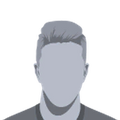

In [76]:
from PIL import Image

Image.open(img_list[0])

In [77]:
detector = dlib.get_frontal_face_detector()

img = Image.open(img_list[0]).convert('RGB')

dets = detector(np.array(img))
det = dets[0]

x1 = det.left()
y1 = det.top()
x2 = det.right()
y2 = det.bottom()

crop_img = img.crop((x1, y1, x2, y2))
crop_img.save('temp_crop.jpg')

crop_img

IndexError: 

In [ ]:
from arcface import ArcFace

face_rec = ArcFace.ArcFace(model_path='model/model.tflite')

emb = face_rec.calc_emb('temp_crop.jpg')

emb.shape

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(512,)

In [ ]:
emb

array([ 6.47867918e-02, -2.57759094e-02, -3.11493110e-02,  1.24697876e-03,
        2.06241012e-02,  8.36116001e-02,  8.72689039e-02, -5.12429774e-02,
       -8.52992479e-03, -1.36557510e-02,  1.75257288e-02, -1.58866420e-02,
       -4.16094763e-03, -3.07768695e-02, -3.14471871e-02, -1.02570161e-01,
        4.34918627e-02,  5.94099835e-02, -3.58873233e-02,  1.07137553e-01,
       -1.11661945e-02,  2.23675370e-02, -4.15206067e-02,  3.52981165e-02,
        4.59897146e-02, -6.54946715e-02, -1.08386297e-03, -8.47857073e-03,
        4.10073176e-02, -5.68349101e-02, -4.50146617e-03, -4.58329022e-02,
        9.40095112e-02,  2.82155885e-03,  7.24962503e-02, -3.09079699e-03,
        2.14304626e-02,  1.26681015e-01,  3.65121178e-02,  3.91369723e-02,
       -5.56225777e-02, -2.31006648e-02,  6.13091746e-03, -5.37186749e-02,
       -4.87469370e-03,  4.31047101e-03, -9.10688043e-02,  4.80034612e-02,
       -9.47881863e-03,  3.09011228e-02,  2.37768646e-02,  5.50980754e-02,
        4.09278795e-02, -

## Dataset creation

This will take 20 minutes.

In [ ]:
import pickle
import os

if os.path.exists(x_data_filename) is True:
    x_data_file = open(x_data_filename, 'rb')
    x_data = pickle.load(x_data_file)
    x_data_file.close()

    y_data_file = open(y_data_filename, 'rb')
    y_data = pickle.load(y_data_file)
    y_data_file.close()
else:

    img_list = glob(f'{data_imgs_path}/*.png')

    x_data = np.zeros((len(img_list), 512), dtype=np.float32)
    y_data = np.zeros((len(img_list), 1), dtype=np.float32)

    det_failed = 0
    for i, img_path in tqdm(enumerate(img_list)):
        img = Image.open(img_path).convert('RGB')

        dets = detector(np.array(img))

        if len(dets) == 0:
            # let's count how many detection failed.
            #print('failed in detection.')
            det_failed += 1
            continue

        det = dets[0]
        x1 = det.left()
        y1 = det.top()
        x2 = det.right()
        y2 = det.bottom()

        crop_img = img.crop((x1, y1, x2, y2))
        crop_img.save('temp_crop.jpg')

        emb = face_rec.calc_emb('temp_crop.jpg')

        overall = int(os.path.splitext(os.path.basename(img_path))[0].split('_')[1])

        x_data[i] = emb
        y_data[i] = overall

    print("Face detection failed", det_failed, "times.")
    print(x_data.shape)
    print(y_data.shape)

    x_data_file = open(x_data_filename, 'wb')
    pickle.dump(x_data, x_data_file)
    x_data_file.close()

    y_data_file = open(y_data_filename, 'wb')
    pickle.dump(y_data, y_data_file)
    y_data_file.close()

In [ ]:
x_data

array([[-2.17217952e-02,  4.78682779e-02,  5.89070432e-02, ...,
         2.82913152e-05,  5.23255244e-02, -3.85520309e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.02954163e-02, -5.53480461e-02, -2.09330861e-02, ...,
         9.66490805e-03, -4.03317697e-02, -4.41561379e-02],
       ...,
       [ 2.99118552e-03, -1.01174405e-02, -3.12090963e-02, ...,
         3.46333943e-02,  1.39850297e-03, -8.71413015e-03],
       [ 2.18374413e-02, -7.42775872e-02, -4.73538646e-03, ...,
        -4.05535959e-02,  1.14587611e-02, -7.88668990e-02],
       [-4.37698103e-02, -2.84812059e-02, -6.38860161e-04, ...,
        -1.43781463e-02, -9.29635540e-02, -3.77382711e-02]], dtype=float32)

## Training/validation data split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
plt.plot(y_data)
plt.show()

: 

## Model definition

- input: face embedding vector
- output: player's overall score

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Check if the model has been trained and saved.

In [ ]:
model_loaded = False
model_name = 'face-reader-soccer.h5'
retrain = False # if you want to retrain the model, change this to True

if retrain is False and os.path.exists(model_name) is True:
    model = keras.models.load_model(model_name)
    model.summary()
    model_loaded = True


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


2022-11-23 23:49:51.760682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:49:51.761054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jaerock/anaconda3/envs/face-reader-soccer/lib/python3.7/site-packages/cv2/../../lib64:/opt/ros/melodic/lib
2022-11-23 23:49:51.761162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jaerock/anaconda3/envs/face-reader-soccer/lib/python3.7/site-packages/cv2/../../lib64:/opt/ros/melodic/lib
2022-11-23 23:49:51.761

In [ ]:
if retrain is True and model_loaded is False:
    model = keras.Sequential([
        layers.Dense(256, input_shape=(512,), activation="relu"),
        layers.Dense(1),
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    model.summary()

## Training

In [ ]:
if retrain is True and model_loaded is False:
    history = model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=200,
        validation_data=(x_val, y_val)
    )

    model.save(model_name)

    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
else:
    print('A trained model was already loaded.')

: 

## Test with an image

In [ ]:
# %%
test_img_path = 'test_images'
test_img_list = glob(f'{test_img_path}/*.jpg')
n_images = len(test_img_list)
images = []
for i in range(n_images):
    image_name = f'{test_img_path}/{i:02d}.jpg'
    images.append(image_name)

#plt.figure()
for image in images:
    img = Image.open(image)

--2022-11-23 23:50:40--  https://umdearborn.edu/sites/default/files/styles/large/public/group-library/34382/kwon_jaerock.jpg
Resolving umdearborn.edu (umdearborn.edu)... 2620:12a:8001::4, 2620:12a:8000::4, 23.185.0.4
Connecting to umdearborn.edu (umdearborn.edu)|2620:12a:8001::4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25731 (25K) [image/jpeg]
Saving to: ‘00.jpg’

00.jpg              100%[===================>]  25.13K  --.-KB/s    in 0.02s   

2022-11-23 23:50:40 (1.38 MB/s) - ‘00.jpg’ saved [25731/25731]

--2022-11-23 23:50:41--  http://doodler.jrkwon.com/wp-content/uploads/sites/8/2022/09/admin-ajax.jpeg
Resolving doodler.jrkwon.com (doodler.jrkwon.com)... 216.172.184.212
Connecting to doodler.jrkwon.com (doodler.jrkwon.com)|216.172.184.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26693 (26K) [image/jpeg]
Saving to: ‘01.jpg’

01.jpg              100%[===================>]  26.07K  --.-KB/s    in 0.05s   

2022-11-23 23:

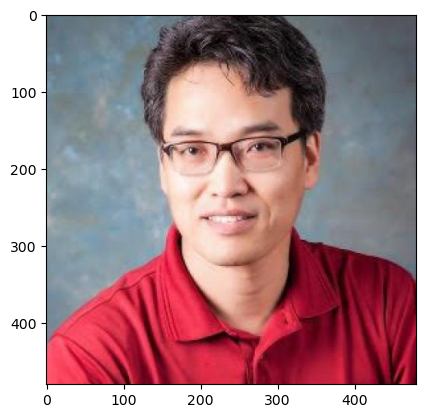

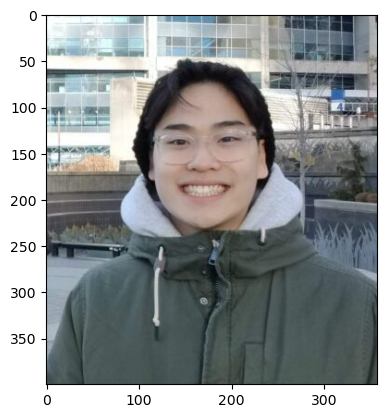

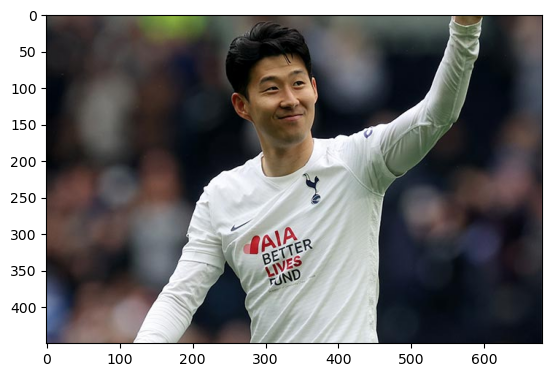

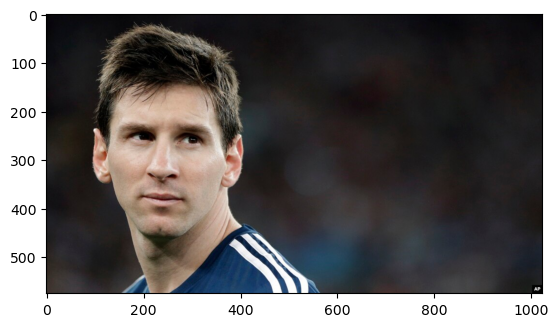

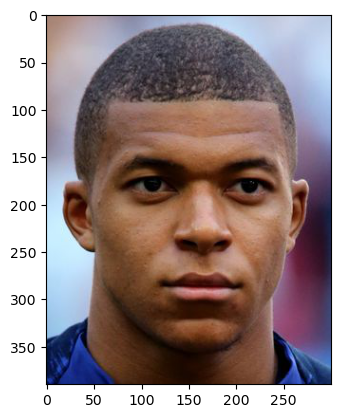

In [ ]:
n_images = len(images)
images = []
for i in range(n_images):
    image_name = f'{test_img_path}/{i:02d}.jpg'
    images.append(image_name)

for image in images:
    img = Image.open(image)
    plt.figure()
    plt.imshow(img)

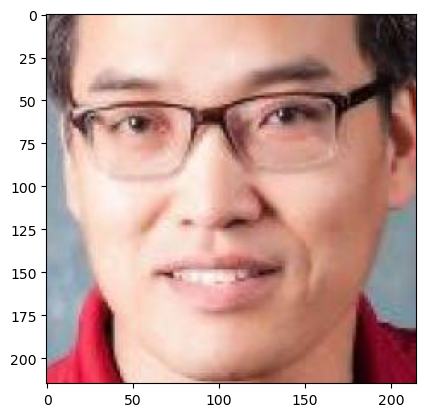

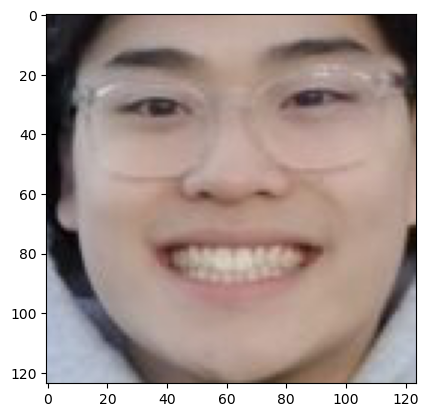

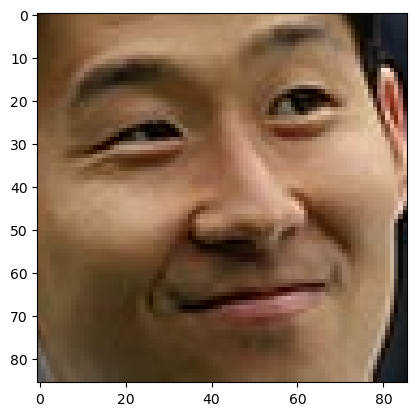

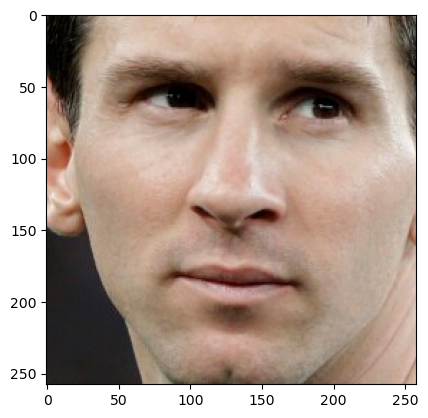

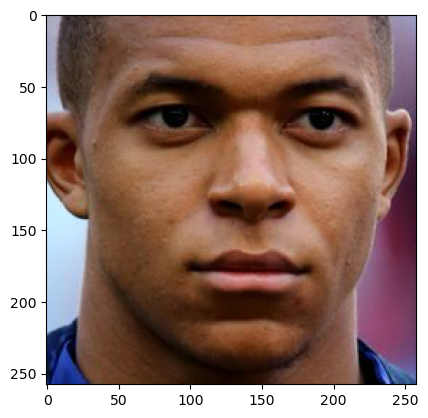

In [ ]:
crop_images = []
for i, image in enumerate(images):
    img = Image.open(image)
    dets = detector(np.array(img))
    if len(dets) == 1:
        det = dets[0]

        x1 = det.left()
        y1 = det.top()
        x2 = det.right()
        y2 = det.bottom()

        crop_img = img.crop((x1, y1, x2, y2))
        crop_image_filename = f'{test_img_path}/crop{i:02d}.jpg'
        crop_images.append(crop_image_filename)
        crop_img.save(crop_image_filename)
        plt.figure()
        plt.imshow(crop_img)
    else:
        print('No face or multiple faces found.')

In [ ]:
crop_images

['crop0.jpg', 'crop1.jpg', 'crop2.jpg', 'crop3.jpg', 'crop4.jpg']

1/1 [==============================] - 0s 89ms/step
Overall performance of a person having face 0 as a soccer player is predicted as 68.20.
1/1 [==============================] - 0s 17ms/step
Overall performance of a person having face 1 as a soccer player is predicted as 62.38.
1/1 [==============================] - 0s 21ms/step
Overall performance of a person having face 2 as a soccer player is predicted as 62.93.
1/1 [==============================] - 0s 20ms/step
Overall performance of a person having face 3 as a soccer player is predicted as 64.66.
1/1 [==============================] - 0s 20ms/step
Overall performance of a person having face 4 as a soccer player is predicted as 64.27.

The best soccer player based on face features is face 0 with 68.20


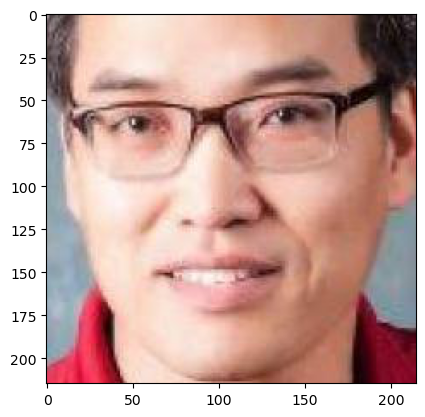

In [ ]:
how_likely = []
for i, crop in enumerate(crop_images):

    emb = face_rec.calc_emb(crop)
    emb = np.expand_dims(emb, axis=0)
    emb.shape

    how_likely.append(model.predict(emb)[0][0])

    print('Overall performance of a person having face {:} as a soccer player is predicted as {:.2f}.'.format(i, how_likely[-1]))

best_idx = how_likely.index(max(how_likely))
print('\nThe best soccer player based on face features is face {:} with {:.2f}'.format(best_idx, how_likely[best_idx]))
img = Image.open(crop_images[best_idx])
plt.figure()
plt.imshow(img)

